# Tutorial - Creating Embeddings from Downloaded Images
#### Author: Antonio Rueda-Toicen
#### [AI Service Center @ Hasso Plattner Institute](https://hpi.de/kisz/home.html)
**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

### 0. Mounting Google Drive and Reading Image Urls

This part of the code is responsible for mounting Google Drive, allowing us to access files stored there.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive




This section reads a list of image URLs from a file. These URLs will be used to download the images.

In [2]:
from pathlib import Path
import os
artist_name = 'Refik Anadol'
path = Path(f'/gdrive/MyDrive/art_recommendation/{artist_name}' )

In [3]:
paintings_filenames = os.listdir(path / "paintings")
len(paintings_filenames)

417

### 1. Importing Image Libraries

We'll start by importing the necessary libraries that will help us in manipulating images and working with images.

In [4]:
from PIL import Image



### 2. Loading an Image

Here, we'll load an image from an array and convert it into a format suitable for further processing.

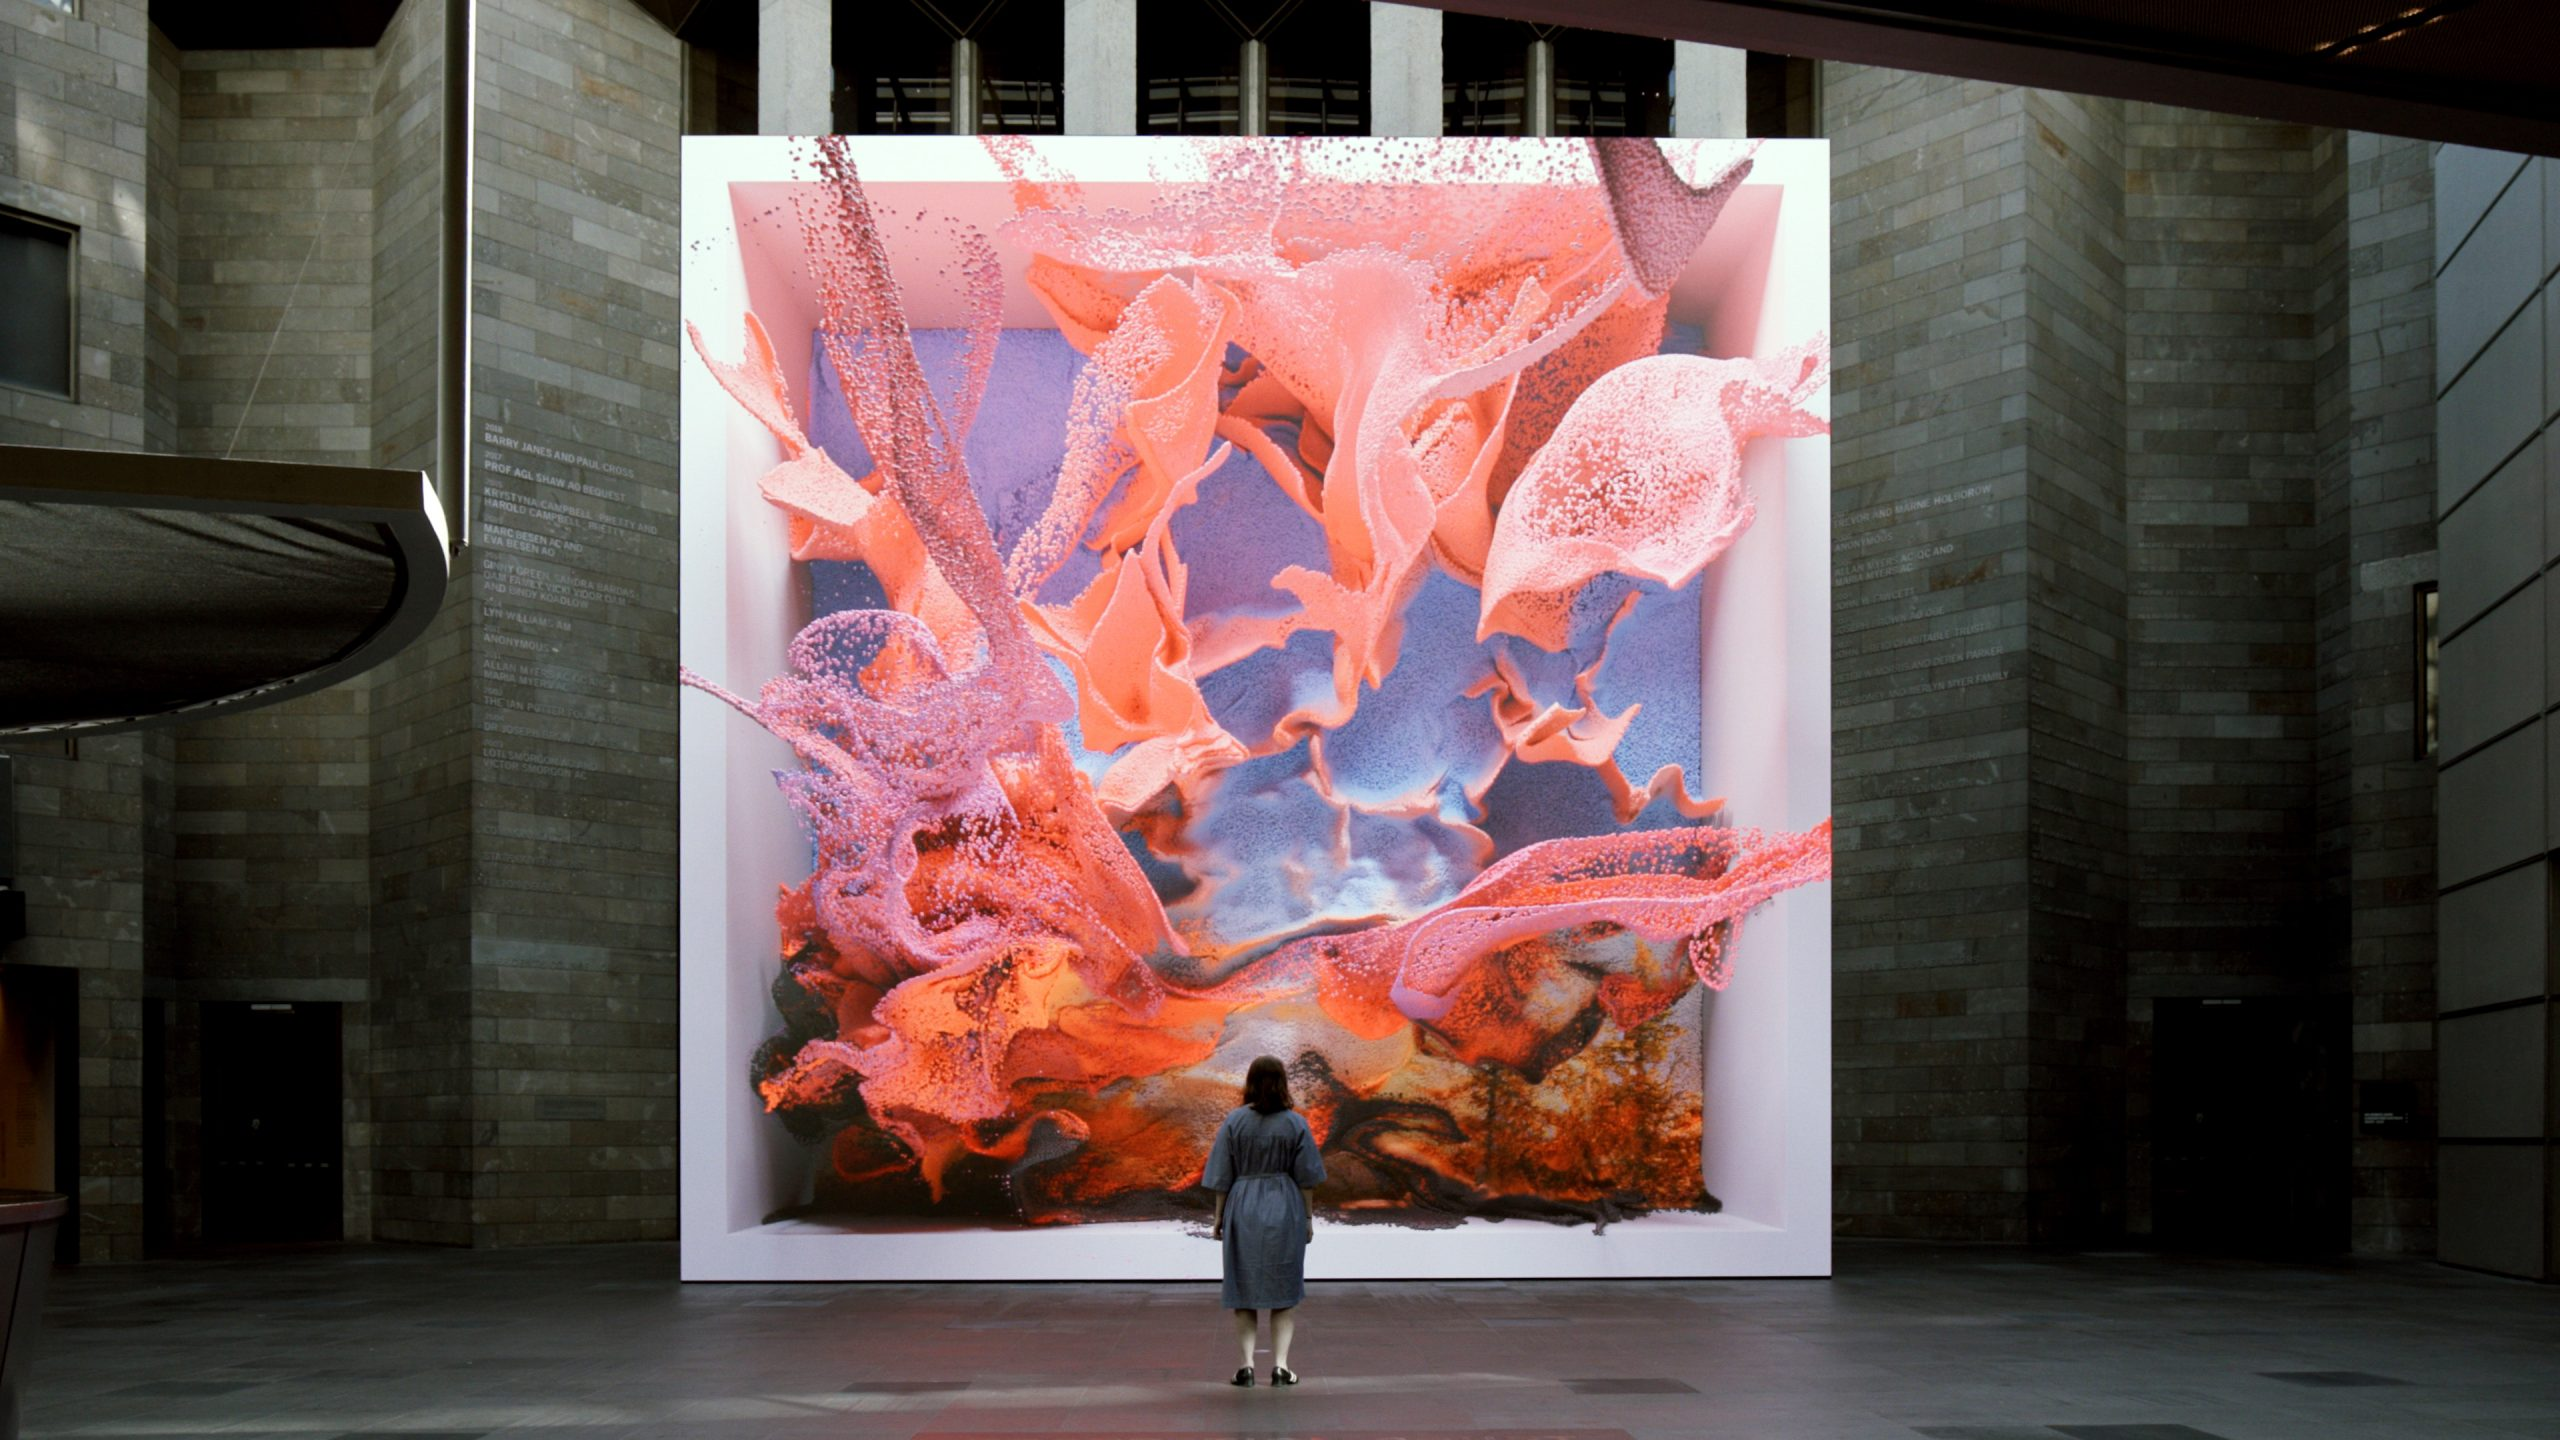

In [5]:
filename1 = path / "paintings" / paintings_filenames[0]
image = Image.open(filename1)
image

### 3. Defining and Initializing Image Embedding Model

We will define a model that can convert images into numerical vectors called embeddings. This model is then initialized for usage. **Don't worry about the details of this model.** For now, you can treat it as a black box that turns images into vectors of numbers. Similar images will turn into vectors that are close to each other.

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet34_Weights
from PIL import Image

# Load the pretrained ResNet34 model
model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# Remove the final classification layer to get embeddings
model = torch.nn.Sequential(*list(model.children())[:-1])

# Set model to evaluation mode
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Function to extract embeddings from an image
def extract_embedding(image):
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(image)
    return embedding.squeeze().numpy()

# Example usage
embedding = extract_embedding(image)
print(embedding.shape)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 129MB/s]


(512,)


### 5. Setting Up Paths

We define the paths where the images and other related data are located. This helps in organizing and accessing the files easily.

### 7. Creating Image Embeddings

Here, we use the initialized model to convert an image into an embedding. This numerical representation can be used for various purposes in machine learning.

In [7]:
embedding1 = extract_embedding(image)
embedding1

array([1.87893569e+00, 7.13622332e-01, 2.69743991e+00, 2.65480137e+00,
       8.91410351e-01, 9.01313186e-01, 4.64846909e-01, 3.26147854e-01,
       1.36382294e+00, 1.16255856e+00, 8.55096340e-01, 7.15461910e-01,
       2.19656086e+00, 2.20537734e+00, 1.60396862e+00, 1.52165103e+00,
       1.34058371e-01, 2.01383495e+00, 8.59114587e-01, 1.01176190e+00,
       8.22718740e-01, 4.83704716e-01, 2.91765404e+00, 3.23405647e+00,
       6.39292896e-01, 1.58537853e+00, 2.65889502e+00, 1.65000820e+00,
       1.52587175e+00, 2.81472087e+00, 1.68522036e+00, 8.87926042e-01,
       1.61060071e+00, 1.63242817e-01, 2.14310125e-01, 2.20039234e-01,
       6.04500584e-02, 1.00654340e+00, 7.20946491e-01, 5.27414858e-01,
       1.36242485e+00, 6.03296101e-01, 5.27119398e-01, 1.29233360e+00,
       2.20857978e-01, 1.28788602e+00, 5.30761659e-01, 7.64147699e-01,
       2.91425467e+00, 1.11794043e+00, 9.31314290e-01, 3.62589806e-01,
       6.96046710e-01, 9.28208351e-01, 1.38388231e-01, 7.12310374e-01,
      

In [8]:
# Now we put the image embedding into a dictionary with the filename as key
sample_dict = {filename1:embedding1}
sample_dict.keys()

dict_keys([PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_2.jpg')])

In [9]:
paintings_embedded_dict = {}
for filename in paintings_filenames:
  painting_path = path / "paintings" / filename
  try:
    imag = Image.open(painting_path).convert("RGB")

    embed = extract_embedding(imag)
    paintings_embedded_dict[painting_path] = embed
  except:
    continue

### 9. Saving Embeddings

Once the images are converted into embeddings, we save them to a file for future use.

In [10]:
# check out the integrity of our pickle file
import pickle
with open(path / 'paintings_embeddings.pickle', 'wb') as handle:
    pickle.dump(paintings_embedded_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path / 'paintings_embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

assert len(b.keys()) == len(paintings_embedded_dict.keys())

### 10. Checking the Format of the Keys in Our Dictionary
Each key in our dictionary should have the [**full path**](https://courses.cs.washington.edu/courses/cse140/13wi/file-interaction.html#:~:text=Absolute%20and%20Relative%20file%20paths&text=An%20absolute%20file%20path%20describes,For%20example%2C%20example_directory.), not the relative path to the images. We can check this by inspecting the filenames and using `Image.open()`.

In [11]:
# These should be fully formed paths, we should be able to open all of these images
# from Google Drive
b.keys()

dict_keys([PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_2.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_5.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_6.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_7.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_8.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_9.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_10.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/paintings/paintings_Refik Anadol artworks_Image_11.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/Refik Anadol/

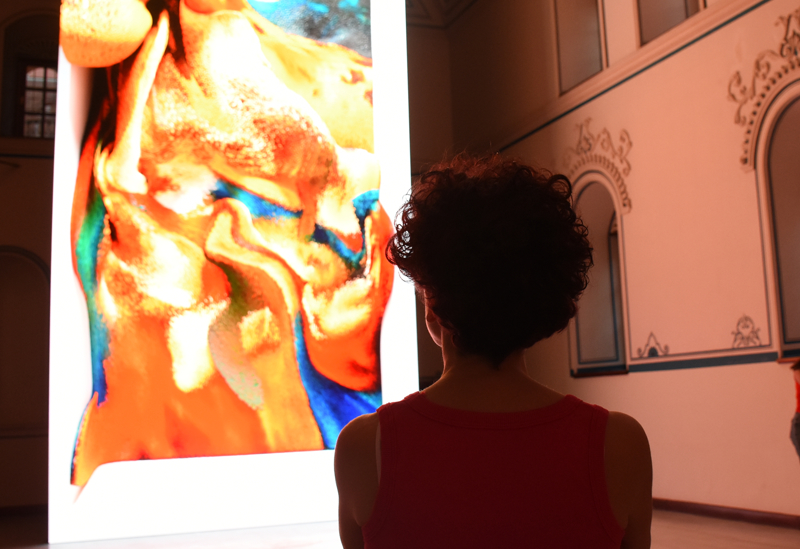

In [12]:
# Check that the keys correspond to valid paths
Image.open(list(b.keys())[-1])

## References

* Adrian Rosebrok's [guide on downloading from Google Images](https://pyimagesearch.com/2018/04/09/how-to-quickly-build-a-deep-learning-image-dataset/)